In [2]:
!ls

__init__.py    client.ipynb   models.py      scraper.py
__pycache__    data           processtext.py


### Standard module imports:

In [445]:
from collections import defaultdict
import importlib
import re

import numpy as np
import pandas as pd
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context(context='talk')

#import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

# spacy for lemmatization
import spacy

from nltk.tokenize.regexp import RegexpTokenizer

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import phrases


from gensim import corpora, models, similarities, matutils
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.porter import PorterStemmer
from gensim.models.ldamodel import LdaModel


from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans



import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


### Project imports:

In [490]:
#import scraper
import processtext 
import models

** Load Transcripts:**

In [491]:
#importlib.reload(processtext)

#transcripts = processtext.main()

models_dict = models.main()

{'Hannity': 120, 'Ingraham': 120, 'Maddow': 134, 'ODonnel': 132}
Number of episosdes, combined = 506
Number of FOX episodes = 240
Number of MSNBC episodes = 266
MSNBC


2018-06-01 18:16:21,058 : INFO : collecting all words and their counts
2018-06-01 18:16:21,060 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-06-01 18:16:23,892 : INFO : collected 494524 word types from a corpus of 770674 words (unigram + bigrams) and 266 sentences
2018-06-01 18:16:23,893 : INFO : using 494524 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
/Users/timcodes/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2018-06-01 18:16:28,098 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-01 18:16:28,832 : INFO : built Dictionary(16886 unique tokens: ['17', '1952', '1960', '1964', '1977']...) from 266 documents (total 658318 corpus positions)
2018-06-01 18:16:29,411 : INFO : using symmetric alpha a

2018-06-01 18:17:01,898 : INFO : topic diff=0.091418, rho=0.353553
2018-06-01 18:17:04,940 : INFO : -8.379 per-word bound, 332.9 perplexity estimate based on a held-out corpus of 266 documents with 658318 words
2018-06-01 18:17:04,941 : INFO : PROGRESS: pass 7, at document #266/266
2018-06-01 18:17:06,092 : INFO : topic #0 (0.333): 0.005*"white_house" + 0.005*"campaign" + 0.005*"russia" + 0.004*"investigation" + 0.004*"quote" + 0.004*"day" + 0.004*"russian" + 0.004*"case" + 0.004*"question" + 0.004*"lawyer"
2018-06-01 18:17:06,093 : INFO : topic #1 (0.333): 0.004*"white_house" + 0.004*"republican" + 0.004*"saying" + 0.004*"investigation" + 0.004*"actually" + 0.003*"day" + 0.003*"kind" + 0.003*"case" + 0.003*"story" + 0.003*"united"
2018-06-01 18:17:06,095 : INFO : topic #2 (0.333): 0.008*"republican" + 0.005*"vote" + 0.005*"white_house" + 0.005*"democrat" + 0.004*"day" + 0.004*"roy_moore" + 0.003*"alabama" + 0.003*"kind" + 0.003*"point" + 0.003*"senate"
2018-06-01 18:17:06,096 : INFO :

FOX


2018-06-01 18:17:45,125 : INFO : collecting all words and their counts
2018-06-01 18:17:45,126 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-06-01 18:17:46,590 : INFO : collected 452647 word types from a corpus of 666034 words (unigram + bigrams) and 240 sentences
2018-06-01 18:17:46,590 : INFO : using 452647 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2018-06-01 18:17:49,736 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-01 18:17:50,332 : INFO : built Dictionary(16458 unique tokens: ['100_percent', '15_second', '18_month', '20', '2008']...) from 240 documents (total 568419 corpus positions)
2018-06-01 18:17:50,775 : INFO : using symmetric alpha at 0.3333333333333333
2018-06-01 18:17:50,776 : INFO : using symmetric eta at 0.3333333333333333
2018-06-01 18:17:50,780 : INFO : using serial LDA version on this node
2018-06-01 18:17:50,788 : INFO : running online (multi-pass) LDA training, 3 to

2018-06-01 18:18:13,332 : INFO : topic #1 (0.333): 0.004*"media_" + 0.004*"need" + 0.004*"actually" + 0.004*"american" + 0.004*"country" + 0.003*"fbi" + 0.003*"democrat" + 0.003*"didnt" + 0.003*"saying" + 0.003*"good"
2018-06-01 18:18:13,334 : INFO : topic #2 (0.333): 0.006*"fbi" + 0.005*"investigation" + 0.005*"james_comey" + 0.004*"american" + 0.004*"robert_mueller" + 0.004*"need" + 0.004*"information" + 0.003*"hillary_clinton" + 0.003*"fact" + 0.003*"saying"
2018-06-01 18:18:13,336 : INFO : topic diff=0.085166, rho=0.333333
2018-06-01 18:18:15,399 : INFO : -8.463 per-word bound, 352.9 perplexity estimate based on a held-out corpus of 240 documents with 568419 words
2018-06-01 18:18:15,400 : INFO : PROGRESS: pass 8, at document #240/240
2018-06-01 18:18:16,099 : INFO : topic #0 (0.333): 0.005*"democrat" + 0.004*"country" + 0.004*"need" + 0.004*"actually" + 0.003*"good" + 0.003*"issue" + 0.003*"republican" + 0.003*"great" + 0.003*"guy" + 0.003*"saying"
2018-06-01 18:18:16,101 : INFO :

combined


2018-06-01 18:19:04,309 : INFO : collecting all words and their counts
2018-06-01 18:19:04,310 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-06-01 18:19:07,406 : INFO : collected 856445 word types from a corpus of 1436708 words (unigram + bigrams) and 506 sentences
2018-06-01 18:19:07,407 : INFO : using 856445 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2018-06-01 18:19:14,175 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-01 18:19:15,430 : INFO : built Dictionary(25068 unique tokens: ['100_percent', '15_second', '18_month', '20', '2008']...) from 506 documents (total 1227261 corpus positions)
2018-06-01 18:19:16,459 : INFO : using symmetric alpha at 0.3333333333333333
2018-06-01 18:19:16,460 : INFO : using symmetric eta at 0.3333333333333333
2018-06-01 18:19:16,465 : INFO : using serial LDA version on this node
2018-06-01 18:19:16,478 : INFO : running online (multi-pass) LDA training, 3 

2018-06-01 18:20:04,351 : INFO : topic #0 (0.333): 0.004*"democrat" + 0.004*"need" + 0.004*"country" + 0.004*"american" + 0.004*"actually" + 0.003*"saying" + 0.003*"good" + 0.003*"didnt" + 0.003*"great" + 0.003*"issue"
2018-06-01 18:20:04,354 : INFO : topic #1 (0.333): 0.005*"republican" + 0.005*"white_house" + 0.004*"day" + 0.004*"campaign" + 0.004*"investigation" + 0.003*"case" + 0.003*"story" + 0.003*"question" + 0.003*"kind" + 0.003*"saying"
2018-06-01 18:20:04,357 : INFO : topic #2 (0.333): 0.007*"fbi" + 0.005*"investigation" + 0.005*"russian" + 0.004*"information" + 0.004*"russia" + 0.004*"campaign" + 0.004*"robert_mueller" + 0.003*"james_comey" + 0.003*"american" + 0.003*"case"
2018-06-01 18:20:04,359 : INFO : topic diff=0.088945, rho=0.333333
2018-06-01 18:20:08,782 : INFO : -8.534 per-word bound, 370.6 perplexity estimate based on a held-out corpus of 506 documents with 1227261 words
2018-06-01 18:20:08,783 : INFO : PROGRESS: pass 8, at document #506/506
2018-06-01 18:20:10,87

** Gather all the transcript _documents_ in `documents`:**

In [469]:
documents = []
msnbc_documents = []
fox_documents = []

doc2network = dict()

for i, tr in enumerate(transcripts):
    episode = processtext.Episode(tr)
    documents.append(episode.transcript)
    
    doc2network[i] = episode.network
    if episode.network == 'FOX':
        fox_documents.append(episode.transcript)
    elif episode.network == 'MSNBC':
        msnbc_documents.append(episode.transcript)
    else:
        print('NO Network assignment.')

print(f"Number of episosdes, combined = {len(documents)}")
print(f"Number of FOX episodes = {len(fox_documents)}")
print(f"Number of MSNBC episodes = {len(msnbc_documents)}")

Number of episosdes, combined = 506
Number of FOX episodes = 240
Number of MSNBC episodes = 266


In [405]:
stopwords = list(STOPWORDS)
stopwords = stopwords + ['s', 't', 'thei', 'thi', 'hi', 'wa', 'ha', 'o', 'ar', 
                         'right', 'sai', 'becaus','new', 'think', 'know', 'like', 
                         'said', 'time', 'tonight', 'dont', 'people', 
                         'peopl', 'want', 'todai', 'today', 'thing', 'look', 'let', 'come', 
                         'wai', 'thats', 'u', 'got', 'im', 'year', 'going', 'lot', 
                         'way', 'news', 'mean','president_trump', 'president',
                         'state', 'yes', 'theyre', 'youre','doe'] # 'didnt']

## Create Latent Dirichlet Allocation & Latent Semantic Index models

Features:
- Tokenize and lemmatize
- Analyze word frequency and exclude rare terms
- Include bigrams to group common co-occurring terms, like "mueller" and "investigation"
- Create separate id2word dictionaries and corpora for Fox, MSNBC, and combined. 
- Create separate LDA and LSI models

In [406]:
models_dict = dict()

lemmatizer = WordNetLemmatizer()

for key, docs in {'MSNBC': msnbc_documents, 'FOX': fox_documents, 'combined': documents}.items():
    print(key)
    
    num_topics = 3
    
    texts = [[lemmatizer.lemmatize(word) for word in document.split() if lemmatizer.lemmatize(word) not in stopwords]
              for document in docs]
    
    bigram = gensim.models.Phrases(texts)
    texts = [bigram[line] for line in texts]

    # remove words that appear only twice
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
   
    texts = [[token for token in text if frequency[token] > 2]
             for text in texts]
    
    dictionary = corpora.Dictionary(texts)
    
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    lda = LdaModel(corpus=corpus, 
                   num_topics=num_topics,
                   minimum_probability=0.03, 
                   id2word=dictionary, 
                   passes=12)
    
    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=num_topics)
    index = similarities.MatrixSimilarity(lsi[corpus])
    
    models_dict[key] = {'model':lda,
                        'corpus':corpus,
                        'id2word':dictionary,
                        'lsi': lsi,
                        'index': index,
                        }

MSNBC


2018-06-01 07:04:02,298 : INFO : collecting all words and their counts
2018-06-01 07:04:02,299 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-06-01 07:04:03,902 : INFO : collected 494524 word types from a corpus of 770674 words (unigram + bigrams) and 266 sentences
2018-06-01 07:04:03,903 : INFO : using 494524 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
/Users/timcodes/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2018-06-01 07:04:07,634 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-01 07:04:08,220 : INFO : built Dictionary(16886 unique tokens: ['17', '1952', '1960', '1964', '1977']...) from 266 documents (total 658318 corpus positions)
2018-06-01 07:04:08,778 : INFO : using symmetric alpha a

2018-06-01 07:04:31,243 : INFO : -8.388 per-word bound, 335.0 perplexity estimate based on a held-out corpus of 266 documents with 658318 words
2018-06-01 07:04:31,243 : INFO : PROGRESS: pass 7, at document #266/266
2018-06-01 07:04:31,958 : INFO : topic #0 (0.333): 0.006*"white_house" + 0.005*"investigation" + 0.005*"campaign" + 0.005*"fbi" + 0.004*"republican" + 0.004*"quote" + 0.004*"day" + 0.003*"story" + 0.003*"russia" + 0.003*"information"
2018-06-01 07:04:31,960 : INFO : topic #1 (0.333): 0.007*"republican" + 0.005*"vote" + 0.004*"white_house" + 0.004*"democrat" + 0.003*"day" + 0.003*"roy_moore" + 0.003*"actually" + 0.003*"country" + 0.003*"russia" + 0.003*"campaign"
2018-06-01 07:04:31,961 : INFO : topic #2 (0.333): 0.005*"question" + 0.005*"robert_mueller" + 0.004*"white_house" + 0.004*"case" + 0.004*"lawyer" + 0.004*"day" + 0.004*"saying" + 0.004*"investigation" + 0.004*"kind" + 0.003*"story"
2018-06-01 07:04:31,962 : INFO : topic diff=0.078071, rho=0.333333
2018-06-01 07:04:

FOX


2018-06-01 07:05:01,116 : INFO : collecting all words and their counts
2018-06-01 07:05:01,117 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-06-01 07:05:02,487 : INFO : collected 452647 word types from a corpus of 666034 words (unigram + bigrams) and 240 sentences
2018-06-01 07:05:02,488 : INFO : using 452647 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2018-06-01 07:05:05,565 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-01 07:05:06,162 : INFO : built Dictionary(16458 unique tokens: ['100_percent', '15_second', '18_month', '20', '2008']...) from 240 documents (total 568419 corpus positions)
2018-06-01 07:05:06,619 : INFO : using symmetric alpha at 0.3333333333333333
2018-06-01 07:05:06,620 : INFO : using symmetric eta at 0.3333333333333333
2018-06-01 07:05:06,623 : INFO : using serial LDA version on this node
2018-06-01 07:05:06,631 : INFO : running online (multi-pass) LDA training, 3 to

2018-06-01 07:05:28,249 : INFO : topic #1 (0.333): 0.005*"country" + 0.004*"actually" + 0.004*"need" + 0.004*"democrat" + 0.003*"issue" + 0.003*"good" + 0.003*"american" + 0.003*"saying" + 0.003*"didnt" + 0.003*"great"
2018-06-01 07:05:28,250 : INFO : topic #2 (0.333): 0.005*"fbi" + 0.004*"democrat" + 0.004*"need" + 0.004*"american" + 0.004*"information" + 0.003*"fact" + 0.003*"country" + 0.003*"actually" + 0.003*"media_" + 0.003*"didnt"
2018-06-01 07:05:28,251 : INFO : topic diff=0.079805, rho=0.333333
2018-06-01 07:05:30,157 : INFO : -8.467 per-word bound, 353.9 perplexity estimate based on a held-out corpus of 240 documents with 568419 words
2018-06-01 07:05:30,158 : INFO : PROGRESS: pass 8, at document #240/240
2018-06-01 07:05:30,817 : INFO : topic #0 (0.333): 0.005*"investigation" + 0.005*"fbi" + 0.005*"james_comey" + 0.004*"robert_mueller" + 0.004*"american" + 0.004*"media_" + 0.004*"hillary_clinton" + 0.003*"democrat" + 0.003*"saying" + 0.003*"need"
2018-06-01 07:05:30,818 : IN

combined


2018-06-01 07:06:18,673 : INFO : collecting all words and their counts
2018-06-01 07:06:18,673 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-06-01 07:06:21,712 : INFO : collected 856445 word types from a corpus of 1436708 words (unigram + bigrams) and 506 sentences
2018-06-01 07:06:21,713 : INFO : using 856445 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2018-06-01 07:06:28,472 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-01 07:06:29,682 : INFO : built Dictionary(25068 unique tokens: ['100_percent', '15_second', '18_month', '20', '2008']...) from 506 documents (total 1227261 corpus positions)
2018-06-01 07:06:30,671 : INFO : using symmetric alpha at 0.3333333333333333
2018-06-01 07:06:30,672 : INFO : using symmetric eta at 0.3333333333333333
2018-06-01 07:06:30,679 : INFO : using serial LDA version on this node
2018-06-01 07:06:30,694 : INFO : running online (multi-pass) LDA training, 3 

2018-06-01 07:07:15,823 : INFO : PROGRESS: pass 7, at document #506/506
2018-06-01 07:07:17,468 : INFO : topic #0 (0.333): 0.006*"fbi" + 0.005*"investigation" + 0.004*"russian" + 0.004*"russia" + 0.004*"campaign" + 0.004*"information" + 0.003*"american" + 0.003*"james_comey" + 0.003*"day" + 0.003*"fact"
2018-06-01 07:07:17,469 : INFO : topic #1 (0.333): 0.006*"republican" + 0.006*"democrat" + 0.004*"country" + 0.004*"need" + 0.003*"actually" + 0.003*"american" + 0.003*"vote" + 0.003*"saying" + 0.003*"good" + 0.003*"woman"
2018-06-01 07:07:17,471 : INFO : topic #2 (0.333): 0.005*"white_house" + 0.004*"case" + 0.004*"robert_mueller" + 0.004*"question" + 0.004*"lawyer" + 0.004*"story" + 0.004*"day" + 0.003*"investigation" + 0.003*"kind" + 0.003*"saying"
2018-06-01 07:07:17,472 : INFO : topic diff=0.083689, rho=0.333333
2018-06-01 07:07:22,065 : INFO : -8.535 per-word bound, 370.9 perplexity estimate based on a held-out corpus of 506 documents with 1227261 words
2018-06-01 07:07:22,066 : I

In [485]:
# Functions for using the Latent Semantic Index models to create queries:

def search_corpus(query, top_x=10):
    """
    
    Expects a list of strings.
    """
    
    ref = models_dict['combined']
    
    vec_bow = ref['id2word'].doc2bow(query)
    vec_lsi = ref['lsi'][vec_bow] # convert the query to LSI space
    sims = index[vec_lsi]
    sim_tups = list(enumerate(sims))

    return [doc2network[num] for num in sorted(range(len(sims)), key=lambda i: sims[i], reverse=True)[:top_x]]


def query_to_n_grams(query, n=3):
    """ Takes a query and turns its individual terms into n-grams. For illustration purposes only.
    """
    qs = query.split()
    n_grams = []
    for i, q in enumerate(qs[:-(n-1)]):
        #print(i)
        n_grams.append(qs[i:i+n])
    return n_grams


def percent_fox(list_):
    """ Takes a list of the form, e.g. ['FOX', 'MSNBC', 'FOX', 'FOX'], and returns the fraction of strings that are equal to FOX.
    """
    hist = defaultdict(int)
    for item in list_:
        hist[item] += 1
        
    return hist['FOX']/len(list_)

In [457]:
query = "putin stormy_daniels russia fbi investigation robert_mueller james_comey collusion  hillary_clinton"  
ans = search_corpus(query.split(), top_x=10) 
percent_fox(ans)

def query_topics(query):
    ans = search_corpus(query.split(), top_x=10) 
    percent_fox(ans)
    
    

0.0

In [486]:
def get_ngram_query_tuples(query):
    percent_fox_list = []
    for gram in query_to_n_grams(query):
        print('gram: ',gram)
        ans = search_corpus(gram, top_x=10)
        print('ans: ',ans)
        percent_fox(ans)
        print('fract', percent_fox(ans))
        percent_fox_list.append((" ".join(gram), percent_fox(ans)))

    return sorted(percent_fox_list, key=lambda x: x[1])

In [487]:
get_ngram_query_tuples(query)

gram:  ['putin', 'stormy_daniels', 'russia']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC']
fract 0.0
gram:  ['stormy_daniels', 'russia', 'fbi']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'FOX', 'MSNBC', 'MSNBC', 'MSNBC']
fract 0.1
gram:  ['russia', 'fbi', 'investigation']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'FOX', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC']
fract 0.1
gram:  ['fbi', 'investigation', 'robert_mueller']
ans:  ['FOX', 'MSNBC', 'FOX', 'MSNBC', 'MSNBC', 'FOX', 'FOX', 'MSNBC', 'MSNBC', 'FOX']
fract 0.5
gram:  ['investigation', 'robert_mueller', 'comey']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC']
fract 0.0
gram:  ['robert_mueller', 'comey', 'collusion']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'FOX', 'MSNBC', 'MSNBC']
fract 0.1
gram:  ['comey', 'collusion', 'hillary_clinton']
ans:  ['FOX', 'FOX', 'FOX', 'FOX', 'FOX', 'FO

[('putin stormy_daniels russia', 0.0),
 ('investigation robert_mueller comey', 0.0),
 ('stormy_daniels russia fbi', 0.1),
 ('russia fbi investigation', 0.1),
 ('robert_mueller comey collusion', 0.1),
 ('fbi investigation robert_mueller', 0.5),
 ('comey collusion hillary_clinton', 1.0)]

gram:  ['putin', 'stormy_daniels', 'russia']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC']
fract 0.0
gram:  ['stormy_daniels', 'russia', 'fbi']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'FOX', 'MSNBC', 'MSNBC', 'MSNBC']
fract 0.1
gram:  ['russia', 'fbi', 'investigation']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'FOX', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC']
fract 0.1
gram:  ['fbi', 'investigation', 'robert_mueller']
ans:  ['FOX', 'MSNBC', 'FOX', 'MSNBC', 'MSNBC', 'FOX', 'FOX', 'MSNBC', 'MSNBC', 'FOX']
fract 0.5
gram:  ['investigation', 'robert_mueller', 'comey']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC']
fract 0.0
gram:  ['robert_mueller', 'comey', 'collusion']
ans:  ['MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'MSNBC', 'FOX', 'MSNBC', 'MSNBC']
fract 0.1
gram:  ['comey', 'collusion', 'hillary_clinton']
ans:  ['FOX', 'FOX', 'FOX', 'FOX', 'FOX', 'FO

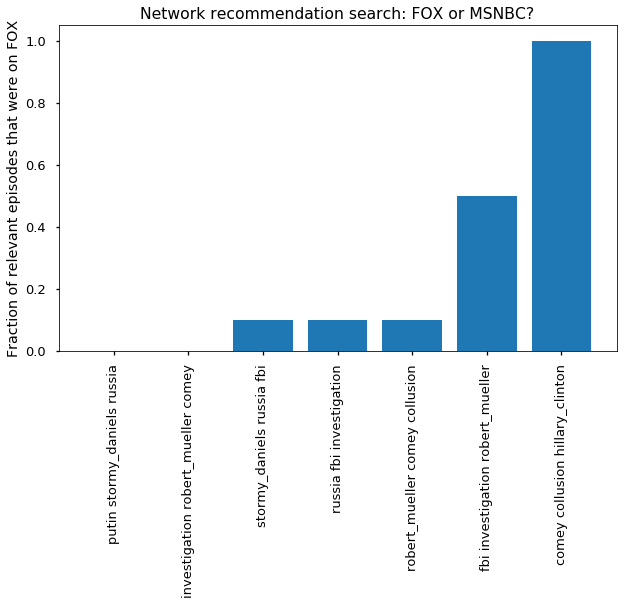

In [488]:
query = "putin stormy_daniels russia fbi investigation robert_mueller comey collusion  hillary_clinton"
percent_fox_list = get_ngram_query_tuples(query)

search_terms = list(zip(*percent_fox_list))[0]
percent_fox = list(zip(*percent_fox_list))[1]
x_pos = np.arange(len(search_terms)) 

plt.figure(figsize=(10,6))
plt.bar(x_pos, percent_fox,align='center')
plt.xticks(x_pos, search_terms, rotation=90) 
plt.ylabel('Fraction of relevant episodes that were on FOX')

plt.title('Network recommendation search: FOX or MSNBC?')
plt.show()

In [412]:
models_dict['combined']['model'].show_topics(num_words=5)

[(0,
  '0.007*"fbi" + 0.005*"investigation" + 0.004*"russian" + 0.004*"information" + 0.004*"russia"'),
 (1,
  '0.006*"democrat" + 0.006*"republican" + 0.004*"country" + 0.004*"need" + 0.003*"actually"'),
 (2,
  '0.006*"white_house" + 0.004*"case" + 0.004*"robert_mueller" + 0.004*"question" + 0.004*"story"')]

In [413]:
models_dict['FOX']['model'].show_topics(num_words=5)

[(0,
  '0.006*"investigation" + 0.005*"fbi" + 0.005*"james_comey" + 0.005*"robert_mueller" + 0.004*"american"'),
 (1,
  '0.005*"country" + 0.004*"democrat" + 0.004*"need" + 0.004*"actually" + 0.003*"good"'),
 (2,
  '0.006*"fbi" + 0.004*"information" + 0.004*"democrat" + 0.004*"american" + 0.004*"need"')]

In [414]:
models_dict['MSNBC']['model'].show_topics(num_words=5)

[(0,
  '0.006*"white_house" + 0.005*"investigation" + 0.005*"fbi" + 0.005*"campaign" + 0.004*"quote"'),
 (1,
  '0.008*"republican" + 0.005*"vote" + 0.005*"democrat" + 0.004*"roy_moore" + 0.003*"white_house"'),
 (2,
  '0.005*"robert_mueller" + 0.005*"question" + 0.004*"white_house" + 0.004*"lawyer" + 0.004*"case"')]

In [409]:
network = 'combined'
vis = pyLDAvis.gensim.prepare(topic_model = models_dict[network]['model'], 
                              corpus = models_dict[network]['corpus'], 
                              dictionary = models_dict[network]['id2word'])
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      36.395252        1       1 -0.063431 -0.003836
2      33.682247        1       2  0.035641 -0.044574
0      29.922503        1       3  0.027790  0.048410, topic_info=      Category         Freq                Term        Total  loglift  logprob
term                                                                          
405    Default  3992.000000                 fbi  3992.000000  30.0000  30.0000
5185   Default  1300.000000       michael_cohen  1300.000000  29.0000  29.0000
298    Default  3872.000000            democrat  3872.000000  28.0000  28.0000
598    Default  1983.000000         james_comey  1983.000000  27.0000  27.0000
8592   Default  1058.000000           roy_moore  1058.000000  26.0000  26.0000
341    Default  1000.000000             dossier  1000.000000  25.0000  25.0000
568    Default  2428.000000         information  2428.000000  24.0000  24.0000
1185   Default  3921.000000         white_house  3921.000000  23.0000  23.0000
947    Default  2768.000000             russian  2768.000000  22.0000  22.0000
643    Default  2246.000000              lawyer  2246.000000  21.0000  21.0000
2598   Default  1911.000000                vote  1911.000000  20.0000  20.0000
2392   Default  1085.000000                memo  1085.000000  19.0000  19.0000
6573   Default   962.000000             alabama   962.000000  18.0000  18.0000
519    Default  1563.000000     hillary_clinton  1563.000000  17.0000  17.0000
943    Default  2738.000000              russia  2738.000000  16.0000  16.0000
583    Default  4163.000000       investigation  4163.000000  15.0000  15.0000
697    Default  1837.000000              media_  1837.000000  14.0000  14.0000
608    Default   568.000000          john_kelly   568.000000  13.0000  13.0000
2541   Default   738.000000  special_prosecutor   738.000000  12.0000  12.0000
934    Default  3288.000000      robert_mueller  3288.000000  11.0000  11.0000
5275   Default   654.000000      stormy_daniels   654.000000  10.0000  10.0000
5183   Default   332.000000    michael_avenatti   332.000000   9.0000   9.0000
866    Default  2185.000000               quote  2185.000000   8.0000   8.0000
3634   Default   533.000000             tax_cut   533.000000   7.0000   7.0000
907    Default  4635.000000          republican  4635.000000   6.0000   6.0000
18461  Default   350.000000              mcgahn   350.000000   5.0000   5.0000
2562   Default   867.000000                 tax   867.000000   4.0000   4.0000
696    Default   531.000000              mccabe   531.000000   3.0000   3.0000
1190   Default  2212.000000               woman  2212.000000   2.0000   2.0000
1026   Default  1655.000000     special_counsel  1655.000000   1.0000   1.0000
...        ...          ...                 ...          ...      ...      ...
750     Topic3   767.013245            official  1518.845337   0.5234  -6.1712
937     Topic3   530.130432      rod_rosenstein   942.911316   0.6307  -6.5406
155     Topic3  1343.351929            campaign  3376.020508   0.2850  -5.6108
188     Topic3   660.453308             clinton  1312.868164   0.5195  -6.3208
53      Topic3  1251.491333            american  3396.840820   0.2080  -5.6816
621     Topic3   627.219177  justice_department  1244.582275   0.5213  -6.3724
391     Topic3  1135.742676                fact  3131.301514   0.1924  -5.7787
903     Topic3   998.413147              report  2581.675781   0.2565  -5.9076
334     Topic3   607.788391            document  1220.384033   0.5095  -6.4039
818     Topic3   627.366211     president_obama  1295.275879   0.4816  -6.3722
1026    Topic3   727.280884     special_counsel  1655.969971   0.3837  -6.2244
900     Topic3   777.272827            remember  1858.317383   0.3349  -6.1579
934     Topic3  1089.948975      robert_mueller  3288.346924   0.1023  -5.8198
485     Topic3  1024.175903                 guy  3036

In [410]:
network = 'FOX'
vis = pyLDAvis.gensim.prepare(topic_model = models_dict[network]['model'], 
                              corpus = models_dict[network]['corpus'], 
                              dictionary = models_dict[network]['id2word'])
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      39.697987        1       1  0.066055 -0.002976
0      34.693695        1       2 -0.037945 -0.028495
2      25.608326        1       3 -0.028110  0.031471, topic_info=     Category         Freq                Term        Total  loglift  logprob
term                                                                         
399   Default  2076.000000                 fbi  2076.000000  30.0000  30.0000
590   Default  1249.000000         james_comey  1249.000000  29.0000  29.0000
337   Default   708.000000             dossier   708.000000  28.0000  28.0000
576   Default  1728.000000       investigation  1728.000000  27.0000  27.0000
932   Default  1242.000000      robert_mueller  1242.000000  26.0000  26.0000
562   Default  1330.000000         information  1330.000000  25.0000  25.0000
514   Default  1274.000000     hillary_clinton  1274.000000  24.0000  24.0000
946   Default   836.000000             russian   836.000000  23.0000  23.0000
185   Default  1034.000000             clinton  1034.000000  22.0000  22.0000
367   Default   738.000000            evidence   738.000000  21.0000  21.0000
1927  Default   264.000000              strzok   264.000000  20.0000  20.0000
693   Default  1522.000000              media_  1522.000000  19.0000  19.0000
2389  Default   592.000000                memo   592.000000  18.0000  18.0000
1025  Default   651.000000     special_counsel   651.000000  17.0000  17.0000
1548  Default   471.000000                 gun   471.000000  16.0000  16.0000
1928  Default   350.000000             student   350.000000  15.0000  15.0000
2421  Default   527.000000         north_korea   527.000000  14.0000  14.0000
1868  Default   619.000000              school   619.000000  13.0000  13.0000
942   Default   787.000000              russia   787.000000  12.0000  12.0000
1760  Default   290.000000        peter_strzok   290.000000  11.0000  11.0000
1951  Default   250.000000        text_message   250.000000  10.0000  10.0000
1505  Default   240.000000          fisa_court   240.000000   9.0000   9.0000
172   Default   207.000000  christopher_steele   207.000000   8.0000   8.0000
7996  Default   304.000000           roy_moore   304.000000   7.0000   7.0000
656   Default   454.000000                 lie   454.000000   6.0000   6.0000
1994  Default   276.000000             uranium   276.000000   5.0000   5.0000
817   Default   965.000000     president_obama   965.000000   4.0000   4.0000
152   Default   953.000000            campaign   953.000000   3.0000   3.0000
620   Default   607.000000                 kid   607.000000   2.0000   2.0000
692   Default   377.000000              mccabe   377.000000   1.0000   1.0000
...       ...          ...                 ...          ...      ...      ...
942    Topic3   321.376740              russia   787.443176   0.4661  -6.1157
152    Topic3   367.773224            campaign   953.939697   0.4091  -5.9809
1020   Topic3   173.497757              source   344.394226   0.6766  -6.7322
386    Topic3   532.771667                fact  1646.087158   0.2342  -5.6103
353    Topic3   321.949341            election   860.042969   0.3797  -6.1140
627    Topic3   253.158737                knew   618.599915   0.4688  -6.3543
693    Topic3   462.529877              media_  1522.208862   0.1710  -5.7516
367    Topic3   280.266907            evidence   738.039062   0.3940  -6.2526
53     Topic3   551.222839            american  2033.229736   0.0570  -5.5762
296    Topic3   568.195557            democrat  2167.856934   0.0232  -5.5459
725    Topic3   541.050659                need  2138.874512  -0.0123  -5.5948
1106   Topic3   302.487640                told   876.753418   0.2981  -6.1763
1085   Topic3   414.712921                tell  1460.973633   0.1030  -5.8608
2173   Topic3   292.305115                deal   874.552429   0.2663  -6.2106
797    Topic3   392.6

In [411]:
network = 'MSNBC'
vis = pyLDAvis.gensim.prepare(topic_model = models_dict[network]['model'], 
                              corpus = models_dict[network]['corpus'], 
                              dictionary = models_dict[network]['id2word'])
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      37.213768        1       1 -0.016531 -0.046356
2      33.924969        1       2 -0.038437  0.035484
1      28.861269        1       3  0.054968  0.010872, topic_info=      Category         Freq                Term        Total  loglift  logprob
term                                                                          
1052   Default  1301.000000                vote  1301.000000  30.0000  30.0000
11040  Default   754.000000           roy_moore   754.000000  29.0000  29.0000
828    Default  2917.000000          republican  2917.000000  28.0000  28.0000
3189   Default   704.000000             alabama   704.000000  27.0000  27.0000
272    Default  1530.000000            democrat  1530.000000  26.0000  26.0000
605    Default  1215.000000       michael_cohen  1215.000000  25.0000  25.0000
348    Default  1807.000000                 fbi  1807.000000  24.0000  24.0000
886    Default  1014.000000              senate  1014.000000  23.0000  23.0000
4452   Default   624.000000  special_prosecutor   624.000000  22.0000  22.0000
1881   Default   587.000000                 tax   587.000000  21.0000  21.0000
5034   Default   298.000000             tax_cut   298.000000  20.0000  20.0000
4017   Default   487.000000      stormy_daniels   487.000000  19.0000  19.0000
792    Default   386.000000                race   386.000000  18.0000  18.0000
14194  Default   213.000000          doug_jones   213.000000  17.0000  17.0000
845    Default  1817.000000      robert_mueller  1817.000000  16.0000  16.0000
551    Default  1754.000000              lawyer  1754.000000  15.0000  15.0000
851    Default   281.000000       rudy_giuliani   281.000000  14.0000  14.0000
2082   Default   704.000000             company   704.000000  13.0000  13.0000
485    Default  1234.000000         information  1234.000000  12.0000  12.0000
109    Default   769.000000                book   769.000000  11.0000  11.0000
3646   Default   361.000000            virginia   361.000000  10.0000  10.0000
1277   Default   193.000000              county   193.000000   9.0000   9.0000
887    Default   765.000000             senator   765.000000   8.0000   8.0000
876    Default   389.000000              school   389.000000   7.0000   7.0000
1053   Default   331.000000               voter   331.000000   6.0000   6.0000
1069   Default   354.000000                 win   354.000000   5.0000   5.0000
788    Default  1996.000000            question  1996.000000   4.0000   4.0000
6643   Default   308.000000          rob_porter   308.000000   3.0000   3.0000
2204   Default   572.000000               flynn   572.000000   2.0000   2.0000
635    Default  1070.000000               night  1070.000000   1.0000   1.0000
...        ...          ...                 ...          ...      ...      ...
14428   Topic3    79.188179      copyright_2017    96.172401   1.0484  -7.7829
138     Topic3   245.255981           candidate   402.611176   0.7470  -6.6525
887     Topic3   404.129272             senator   765.204041   0.6043  -6.1530
2204    Topic3   321.014984               flynn   572.611694   0.6639  -6.3833
635     Topic3   511.324005               night  1070.900879   0.5034  -5.9178
1325    Topic3   230.412949            district   379.172516   0.7446  -6.7149
1972    Topic3   469.455444               woman  1044.424194   0.4430  -6.0032
1760    Topic3   189.453003    republican_party   303.408813   0.7717  -6.9106
1953    Topic3   136.690002               voted   196.329147   0.8806  -7.2371
235     Topic3   591.143372             country  1588.124634   0.2544  -5.7727
101     Topic3   490.861206                 big  1255.678711   0.3034  -5.9586
2338    Topic3   405.603607   national_security   950.102051   0.3915  -6.1494
309     Topic3   474.390442            election  1230.208984   0.2898  -5.9927
688     Topic3   251.202606               party   474